In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# DL 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN, Flatten, Input, TimeDistributed, RepeatVector

tf.keras.backend.set_floatx('float64')

In [2]:
DETotal_data = pd.read_csv('./DETotal.csv')

In [3]:
print(DETotal_data.shape)

(76320, 2)


## Preprocess data

In [7]:
# 독일 1시간당 전력 데이터 -> datatime type으로 변환
DETotal_data['Hourly Time'] = DETotal_data['Hourly Time'].astype('str')
DETotal_data['Hourly Time'] = pd.to_datetime(DETotal_data['Hourly Time'], format='%d.%m.%Y %H:%M')
DETotal_data

,Hourly Time,Hourly Sum
0,2015-01-01 00:00:00,173819
1,2015-01-01 01:00:00,167853
2,2015-01-01 02:00:00,162471
3,2015-01-01 03:00:00,159747
4,2015-01-01 04:00:00,157090
...,...,...
76315,2023-10-01 18:00:00,192045
76316,2023-10-01 19:00:00,186059
76317,2023-10-01 20:00:00,175896
76318,2023-10-01 21:00:00,168698


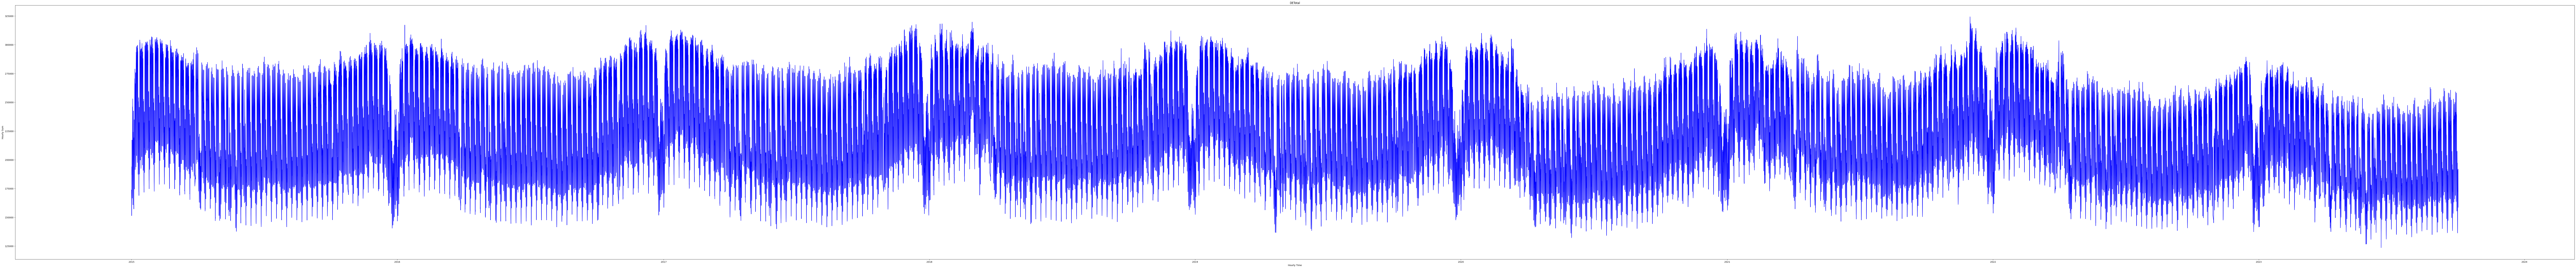

In [8]:
# 독일 1시간당 전력 데이터 -> 그래프 생성
plt.figure(figsize=(200,20))
plt.plot(DETotal_data['Hourly Time'],DETotal_data['Hourly Sum'],color='blue',linestyle='-')

# 그래프 정보 설정
plt.xlabel('Hourly Time') # x 라벨
plt.ylabel('Hourly Sum') # y 라벨
plt.title("DETotal") # 그래프 이름

# 그래프 출력
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
DETotal_data['Hourly Sum'] = scaler.fit_transform(DETotal_data[['Hourly Sum']])

## Train Model

dataset

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [11]:
window_size = 24
dataset = DETotal_data['Hourly Sum'].values
dataset = dataset.reshape(-1,1)
X, y = create_dataset(dataset, window_size)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(len(X) * 0.7)
trainX, remainX = X[:split], X[split:]
trainY, remainY = y[:split], y[split:]

split2 = int(len(remainX) * 0.5)
testX, valX = remainX[:split2], remainX[split2:]
testY, valY = remainY[:split2], remainY[split2:]

모델 정의

In [12]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (239.46 KB)
Trainable params: 30651 (239.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(valX, valY), callbacks=[early_stopping])
model.save('./DETotal_model.h5')

Epoch 1/30
1669/1669 [==============================] - 21s 8ms/step - loss: 0.0352 - val_loss: 0.0086
Epoch 2/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0192 - val_loss: 0.0117
Epoch 3/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0169 - val_loss: 0.0093
Epoch 4/30
1669/1669 [==============================] - 14s 8ms/step - loss: 0.0160 - val_loss: 0.0067
Epoch 5/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0150 - val_loss: 0.0091
Epoch 6/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0141 - val_loss: 0.0078
Epoch 7/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0134 - val_loss: 0.0084
Epoch 8/30
1669/1669 [==============================] - 19s 11ms/step - loss: 0.0129 - val_loss: 0.0091
Epoch 9/30
1669/1669 [==============================] - 13s 8ms/step - loss: 0.0128 - val_loss: 0.0072
Epoch 10/30
1669/1669 [==============================] - 14s 8ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation with TEST SET

In [14]:
predictions = model.predict(testX)
predictions = predictions.reshape(testY.shape)
mape = np.mean(np.abs((testY - predictions) / testY)) * 100
r2 = r2_score(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = np.sqrt(mean_squared_error(testY, predictions))
mmae = np.mean(np.abs((testY - predictions) / testY))

# 성능 지표 계산
print("MAPE:", mape)
print("R2 Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("mMAE:", mmae)

358/358 [==============================] - 2s 3ms/step
MAPE: 33.24174071938347
R2 Score: 0.9947954054071175
MAE: 0.052152464043856275
RMSE: 0.06841919463309694
mMAE: 0.3324174071938347


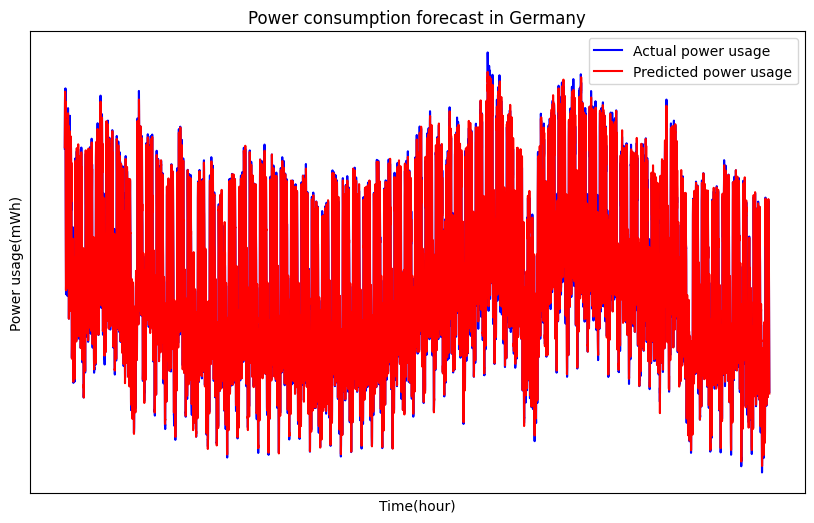

In [15]:
# GT value(blue) VS predicted value(red)
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Actual power usage', color='blue')
plt.plot(predictions, label='Predicted power usage', color='red')
plt.title('Power consumption forecast in Germany')
plt.xlabel('Time(hour)')
plt.ylabel('Power usage(mWh)')
plt.yscale('linear')
plt.xticks([], [])
plt.yticks([], [])
plt.legend()

plt.show()